In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/train.zip" -d /content/Train

In [3]:
#Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.image import load_img

<ipython-input-3-f77c3b274abd>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Check for GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")
tf.config.list_physical_devices("GPU")

GPU available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#reading labels csv file

labels = pd.read_csv('/content/final_labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#describe
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [ ]:
# #total unique breeds

labels['breed'].nunique()

120

In [5]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))


#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [6]:
#One-hot Encoding
input_shape = (331,331,3)

def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        #img = np.expand_dims(img, axis=0)
        #img = processed_image_resnet(img)
        #img = img/255
        images[ix]=img
        #images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

In [7]:
X,y = images_to_array('/content/Train', labels[:])

  0%|          | 0/10222 [00:00<?, ?it/s]

In [8]:
from sklearn.model_selection import train_test_split
 
# Splitting the data set into training and testing data sets
X, X_test, Y, Y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
print(X.shape,X_test.shape)
print(Y.shape,Y_test.shape)

(9199, 331, 331, 3) (1023, 331, 331, 3)
(9199, 120) (1023, 120)


In [9]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [10]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
# Extract features using VGG-16 
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16_preprocessor = preprocess_input
vgg16_features = get_features(VGG16,
                                 vgg16_preprocessor,
                                  img_size, X)

288/288 [==============================] - 21s 41ms/step
Feature maps shape:  (9199, 512)


In [ ]:
from keras.layers import Dropout
from keras.regularizers import l2

In [ ]:
#Prepare Deep net
model = Sequential()
model.add(Dense(1028,input_shape=(vgg16_features.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(vgg16_features, Y,
            batch_size=batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
45/58 [======================>.......] - ETA: 0s - loss: 35.1374 - accuracy: 0.2266

58/58 [==============================] - 1s 6ms/step - loss: 33.7029 - accuracy: 0.2595 - val_loss: 16.6838 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 2/50
44/58 [=====================>........] - ETA: 0s - loss: 22.0059 - accuracy: 0.5075

58/58 [==============================] - 0s 3ms/step - loss: 21.6783 - accuracy: 0.5147 - val_loss: 15.3098 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 3/50
40/58 [===================>..........] - ETA: 0s - loss: 17.1258 - accuracy: 0.5973

58/58 [==============================] - 0s 4ms/step - loss: 16.7381 - accuracy: 0.6010 - val_loss: 13.4881 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 4/50
44/58 [=====================>........] - ETA: 0s - loss: 14.5279 - accuracy: 0.6360

58/58 [==============================] - 0s 3ms/step - loss: 14.3382 - accuracy: 0.6396 - val_loss: 11.5950 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 5/50
44/58 [=====================>........] - ETA: 0s - loss: 12.2044 - accuracy: 0.6710

58/58 [==============================] - 0s 3ms/step - loss: 12.2185 - accuracy: 0.6686 - val_loss: 10.7460 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 6/50
45/58 [======================>.......] - ETA: 0s - loss: 10.5971 - accuracy: 0.7002

58/58 [==============================] - 0s 3ms/step - loss: 10.7664 - accuracy: 0.6960 - val_loss: 10.1508 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 7/50
44/58 [=====================>........] - ETA: 0s - loss: 9.8015 - accuracy: 0.7051

58/58 [==============================] - 0s 3ms/step - loss: 9.8499 - accuracy: 0.7043 - val_loss: 9.4447 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 8/50
41/58 [====================>.........] - ETA: 0s - loss: 8.8517 - accuracy: 0.7323

58/58 [==============================] - 0s 3ms/step - loss: 8.8424 - accuracy: 0.7292 - val_loss: 8.9233 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 9/50
43/58 [=====================>........] - ETA: 0s - loss: 7.9665 - accuracy: 0.7489

58/58 [==============================] - 0s 3ms/step - loss: 8.0883 - accuracy: 0.7453 - val_loss: 8.5654 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 10/50
45/58 [======================>.......] - ETA: 0s - loss: 7.4043 - accuracy: 0.7563

58/58 [==============================] - 0s 3ms/step - loss: 7.4900 - accuracy: 0.7523 - val_loss: 8.2095 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 11/50
43/58 [=====================>........] - ETA: 0s - loss: 7.1143 - accuracy: 0.7518

58/58 [==============================] - 0s 3ms/step - loss: 7.1397 - accuracy: 0.7516 - val_loss: 7.6294 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 12/50
45/58 [======================>.......] - ETA: 0s - loss: 6.4282 - accuracy: 0.7710

58/58 [==============================] - 0s 3ms/step - loss: 6.3580 - accuracy: 0.7703 - val_loss: 7.2379 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 13/50
43/58 [=====================>........] - ETA: 0s - loss: 5.9869 - accuracy: 0.7731

58/58 [==============================] - 0s 3ms/step - loss: 5.9310 - accuracy: 0.7748 - val_loss: 7.0716 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 14/50
45/58 [======================>.......] - ETA: 0s - loss: 5.6570 - accuracy: 0.7786

58/58 [==============================] - 0s 3ms/step - loss: 5.7068 - accuracy: 0.7729 - val_loss: 6.7195 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 15/50
45/58 [======================>.......] - ETA: 0s - loss: 5.4504 - accuracy: 0.7852

58/58 [==============================] - 0s 4ms/step - loss: 5.4654 - accuracy: 0.7797 - val_loss: 6.4111 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 16/50
43/58 [=====================>........] - ETA: 0s - loss: 5.1340 - accuracy: 0.7889

58/58 [==============================] - 0s 3ms/step - loss: 5.1086 - accuracy: 0.7876 - val_loss: 6.3446 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 17/50
44/58 [=====================>........] - ETA: 0s - loss: 5.0119 - accuracy: 0.7757

58/58 [==============================] - 0s 3ms/step - loss: 5.0066 - accuracy: 0.7763 - val_loss: 5.8100 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 18/50
43/58 [=====================>........] - ETA: 0s - loss: 4.6499 - accuracy: 0.7918

58/58 [==============================] - 0s 3ms/step - loss: 4.6865 - accuracy: 0.7877 - val_loss: 5.8590 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 19/50
44/58 [=====================>........] - ETA: 0s - loss: 4.5359 - accuracy: 0.7901

58/58 [==============================] - 0s 3ms/step - loss: 4.5781 - accuracy: 0.7857 - val_loss: 5.6588 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 20/50
45/58 [======================>.......] - ETA: 0s - loss: 4.3961 - accuracy: 0.7972

58/58 [==============================] - 0s 3ms/step - loss: 4.3972 - accuracy: 0.7944 - val_loss: 5.6560 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 21/50
43/58 [=====================>........] - ETA: 0s - loss: 4.1881 - accuracy: 0.7991

58/58 [==============================] - 0s 3ms/step - loss: 4.1240 - accuracy: 0.8039 - val_loss: 5.4058 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 22/50
44/58 [=====================>........] - ETA: 0s - loss: 4.0765 - accuracy: 0.7976

58/58 [==============================] - 0s 3ms/step - loss: 4.1176 - accuracy: 0.7932 - val_loss: 5.1900 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 23/50
43/58 [=====================>........] - ETA: 0s - loss: 4.0235 - accuracy: 0.7972

58/58 [==============================] - 0s 3ms/step - loss: 4.0872 - accuracy: 0.7914 - val_loss: 5.3841 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 24/50
43/58 [=====================>........] - ETA: 0s - loss: 3.9629 - accuracy: 0.7887

58/58 [==============================] - 0s 3ms/step - loss: 3.9684 - accuracy: 0.7845 - val_loss: 5.1911 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 25/50
45/58 [======================>.......] - ETA: 0s - loss: 3.9073 - accuracy: 0.7911

58/58 [==============================] - 0s 3ms/step - loss: 3.9134 - accuracy: 0.7918 - val_loss: 5.1944 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 26/50
45/58 [======================>.......] - ETA: 0s - loss: 3.7723 - accuracy: 0.7964

58/58 [==============================] - 0s 3ms/step - loss: 3.7753 - accuracy: 0.7944 - val_loss: 4.8924 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 27/50
44/58 [=====================>........] - ETA: 0s - loss: 3.6883 - accuracy: 0.8054

58/58 [==============================] - 0s 3ms/step - loss: 3.7140 - accuracy: 0.8007 - val_loss: 4.7626 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 28/50
45/58 [======================>.......] - ETA: 0s - loss: 3.6427 - accuracy: 0.7955

58/58 [==============================] - 0s 3ms/step - loss: 3.5718 - accuracy: 0.8002 - val_loss: 4.6006 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 29/50
44/58 [=====================>........] - ETA: 0s - loss: 3.4993 - accuracy: 0.7974

58/58 [==============================] - 0s 3ms/step - loss: 3.5346 - accuracy: 0.7967 - val_loss: 4.5064 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 30/50
43/58 [=====================>........] - ETA: 0s - loss: 3.4307 - accuracy: 0.8021

58/58 [==============================] - 0s 3ms/step - loss: 3.4963 - accuracy: 0.7941 - val_loss: 4.7820 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 31/50
43/58 [=====================>........] - ETA: 0s - loss: 3.4773 - accuracy: 0.7978

58/58 [==============================] - 0s 3ms/step - loss: 3.4816 - accuracy: 0.7940 - val_loss: 4.5598 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 32/50
45/58 [======================>.......] - ETA: 0s - loss: 3.2739 - accuracy: 0.8061

58/58 [==============================] - 0s 3ms/step - loss: 3.2749 - accuracy: 0.8058 - val_loss: 4.4892 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 33/50
43/58 [=====================>........] - ETA: 0s - loss: 3.2447 - accuracy: 0.8087

58/58 [==============================] - 0s 4ms/step - loss: 3.3069 - accuracy: 0.8004 - val_loss: 4.2191 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 34/50
44/58 [=====================>........] - ETA: 0s - loss: 3.3919 - accuracy: 0.7923

58/58 [==============================] - 0s 3ms/step - loss: 3.3605 - accuracy: 0.7929 - val_loss: 4.2062 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 35/50
45/58 [======================>.......] - ETA: 0s - loss: 3.1446 - accuracy: 0.8139

58/58 [==============================] - 0s 3ms/step - loss: 3.1756 - accuracy: 0.8114 - val_loss: 4.0635 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 36/50
43/58 [=====================>........] - ETA: 0s - loss: 3.1451 - accuracy: 0.7965

58/58 [==============================] - 0s 3ms/step - loss: 3.2185 - accuracy: 0.7902 - val_loss: 4.0886 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 37/50
44/58 [=====================>........] - ETA: 0s - loss: 3.1195 - accuracy: 0.8061

58/58 [==============================] - 0s 3ms/step - loss: 3.1449 - accuracy: 0.8035 - val_loss: 4.3016 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 38/50
44/58 [=====================>........] - ETA: 0s - loss: 3.2251 - accuracy: 0.7939

58/58 [==============================] - 0s 3ms/step - loss: 3.2060 - accuracy: 0.7939 - val_loss: 4.3398 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 39/50
43/58 [=====================>........] - ETA: 0s - loss: 3.1011 - accuracy: 0.7987

58/58 [==============================] - 0s 3ms/step - loss: 3.1013 - accuracy: 0.8015 - val_loss: 4.1343 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 40/50
44/58 [=====================>........] - ETA: 0s - loss: 3.1570 - accuracy: 0.7947

58/58 [==============================] - 0s 3ms/step - loss: 3.2218 - accuracy: 0.7867 - val_loss: 4.2936 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 41/50
44/58 [=====================>........] - ETA: 0s - loss: 3.1316 - accuracy: 0.7960

58/58 [==============================] - 0s 3ms/step - loss: 3.0953 - accuracy: 0.8007 - val_loss: 4.1043 - val_accuracy: 0.7364 - lr: 0.0010
Epoch 42/50
43/58 [=====================>........] - ETA: 0s - loss: 2.9881 - accuracy: 0.8078

58/58 [==============================] - 0s 3ms/step - loss: 3.0156 - accuracy: 0.8060 - val_loss: 4.0627 - val_accuracy: 0.7304 - lr: 0.0010
Epoch 43/50
43/58 [=====================>........] - ETA: 0s - loss: 2.9816 - accuracy: 0.7980

58/58 [==============================] - 0s 3ms/step - loss: 3.0364 - accuracy: 0.7935 - val_loss: 4.1063 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 44/50
42/58 [====================>.........] - ETA: 0s - loss: 2.9395 - accuracy: 0.8077

58/58 [==============================] - 0s 3ms/step - loss: 2.9555 - accuracy: 0.8065 - val_loss: 4.1608 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 45/50
44/58 [=====================>........] - ETA: 0s - loss: 3.0328 - accuracy: 0.7983

58/58 [==============================] - 0s 3ms/step - loss: 3.0760 - accuracy: 0.7936 - val_loss: 4.3124 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 46/50
44/58 [=====================>........] - ETA: 0s - loss: 3.0255 - accuracy: 0.7994

58/58 [==============================] - 0s 3ms/step - loss: 3.0165 - accuracy: 0.8000 - val_loss: 4.0412 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 47/50
45/58 [======================>.......] - ETA: 0s - loss: 2.9669 - accuracy: 0.8002

58/58 [==============================] - 0s 3ms/step - loss: 3.0045 - accuracy: 0.7955 - val_loss: 3.9641 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 48/50
43/58 [=====================>........] - ETA: 0s - loss: 2.9215 - accuracy: 0.7969

58/58 [==============================] - 0s 3ms/step - loss: 2.9617 - accuracy: 0.7955 - val_loss: 4.1104 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 49/50
44/58 [=====================>........] - ETA: 0s - loss: 2.9611 - accuracy: 0.7985

58/58 [==============================] - 0s 3ms/step - loss: 2.9906 - accuracy: 0.7964 - val_loss: 4.0838 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 50/50
45/58 [======================>.......] - ETA: 0s - loss: 2.8749 - accuracy: 0.7993

58/58 [==============================] - 0s 3ms/step - loss: 2.9126 - accuracy: 0.7981 - val_loss: 4.1368 - val_accuracy: 0.7234 - lr: 0.0010


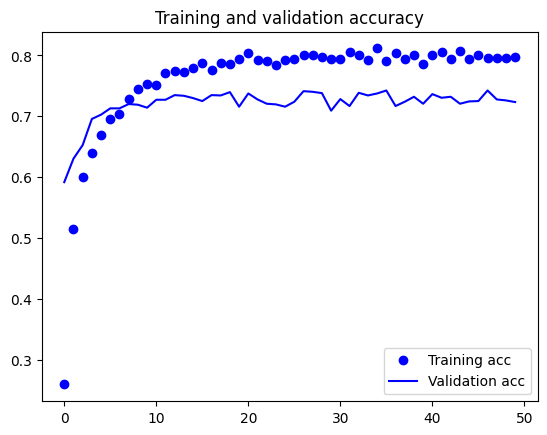

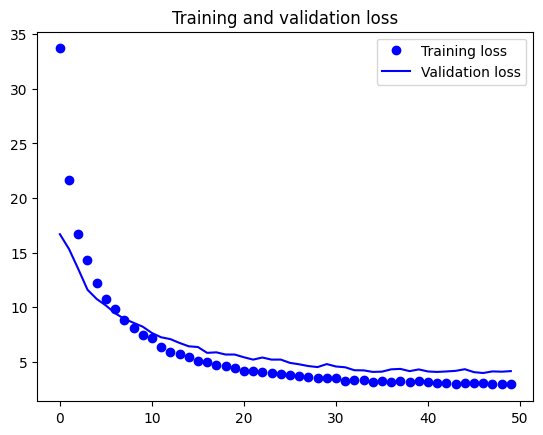

In [ ]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
vgg16_features_test = get_features(VGG16,
                                 vgg16_preprocessor,
                                  img_size, X_test)
Y_pred = model.predict(vgg16_features_test)
score = model.evaluate(vgg16_features_test, Y_test)
print('Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 1s 39ms/step
Feature maps shape:  (1023, 512)
32/32 [==============================] - 0s 2ms/step - loss: 3.8422 - accuracy: 0.7341
Test Set Accuracy: 
  73.41 %


In [ ]:
# Extract features using VGG-19 
from keras.applications.vgg19 import VGG19, preprocess_input
vgg19_preprocessor = preprocess_input
vgg19_features = get_features(VGG19,
                                  vgg19_preprocessor,
                                  img_size, X)

288/288 [==============================] - 13s 45ms/step
Feature maps shape:  (9199, 512)


In [ ]:
#Prepare Deep net
model = Sequential()
model.add(Dense(1028,input_shape=(vgg19_features.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(vgg19_features, Y,
            batch_size=batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
43/58 [=====================>........] - ETA: 0s - loss: 32.4120 - accuracy: 0.2287

58/58 [==============================] - 1s 6ms/step - loss: 30.6676 - accuracy: 0.2765 - val_loss: 16.2247 - val_accuracy: 0.5821 - lr: 0.0010
Epoch 2/50
42/58 [====================>.........] - ETA: 0s - loss: 20.6915 - accuracy: 0.5303

58/58 [==============================] - 0s 3ms/step - loss: 20.3615 - accuracy: 0.5354 - val_loss: 14.1563 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 3/50
43/58 [=====================>........] - ETA: 0s - loss: 15.6692 - accuracy: 0.6148

58/58 [==============================] - 0s 3ms/step - loss: 15.4590 - accuracy: 0.6176 - val_loss: 12.4610 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 4/50
44/58 [=====================>........] - ETA: 0s - loss: 13.4821 - accuracy: 0.6552

58/58 [==============================] - 0s 3ms/step - loss: 13.3173 - accuracy: 0.6569 - val_loss: 11.2914 - val_accuracy: 0.7114 - lr: 0.0010
Epoch 5/50
45/58 [======================>.......] - ETA: 0s - loss: 11.3198 - accuracy: 0.6927

58/58 [==============================] - 0s 3ms/step - loss: 11.2552 - accuracy: 0.6902 - val_loss: 10.2090 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 6/50
44/58 [=====================>........] - ETA: 0s - loss: 9.9796 - accuracy: 0.7113 

58/58 [==============================] - 0s 3ms/step - loss: 9.8539 - accuracy: 0.7130 - val_loss: 9.2405 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 7/50
45/58 [======================>.......] - ETA: 0s - loss: 8.9015 - accuracy: 0.7241

58/58 [==============================] - 0s 3ms/step - loss: 8.9602 - accuracy: 0.7227 - val_loss: 8.5531 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 8/50
45/58 [======================>.......] - ETA: 0s - loss: 7.9822 - accuracy: 0.7497

58/58 [==============================] - 0s 3ms/step - loss: 7.9525 - accuracy: 0.7489 - val_loss: 8.1101 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 9/50
42/58 [====================>.........] - ETA: 0s - loss: 7.1372 - accuracy: 0.7604

58/58 [==============================] - 0s 3ms/step - loss: 7.2079 - accuracy: 0.7596 - val_loss: 7.5676 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 10/50
44/58 [=====================>........] - ETA: 0s - loss: 6.6701 - accuracy: 0.7560

58/58 [==============================] - 0s 3ms/step - loss: 6.7017 - accuracy: 0.7583 - val_loss: 7.3065 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 11/50
45/58 [======================>.......] - ETA: 0s - loss: 6.3222 - accuracy: 0.7778

58/58 [==============================] - 0s 3ms/step - loss: 6.3715 - accuracy: 0.7703 - val_loss: 6.9970 - val_accuracy: 0.7364 - lr: 0.0010
Epoch 12/50
44/58 [=====================>........] - ETA: 0s - loss: 6.0644 - accuracy: 0.7692

58/58 [==============================] - 0s 3ms/step - loss: 6.0055 - accuracy: 0.7690 - val_loss: 6.6364 - val_accuracy: 0.7304 - lr: 0.0010
Epoch 13/50
45/58 [======================>.......] - ETA: 0s - loss: 5.5189 - accuracy: 0.7757

58/58 [==============================] - 0s 3ms/step - loss: 5.4788 - accuracy: 0.7766 - val_loss: 6.3888 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 14/50
44/58 [=====================>........] - ETA: 0s - loss: 5.1737 - accuracy: 0.7850

58/58 [==============================] - 0s 3ms/step - loss: 5.2281 - accuracy: 0.7782 - val_loss: 6.0641 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 15/50
43/58 [=====================>........] - ETA: 0s - loss: 4.9458 - accuracy: 0.7845

58/58 [==============================] - 0s 3ms/step - loss: 4.9569 - accuracy: 0.7838 - val_loss: 6.0171 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 16/50
44/58 [=====================>........] - ETA: 0s - loss: 4.5256 - accuracy: 0.8020

58/58 [==============================] - 0s 3ms/step - loss: 4.5715 - accuracy: 0.7937 - val_loss: 5.6493 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 17/50
44/58 [=====================>........] - ETA: 0s - loss: 4.4058 - accuracy: 0.7940

58/58 [==============================] - 0s 3ms/step - loss: 4.3718 - accuracy: 0.7966 - val_loss: 5.4584 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 18/50
43/58 [=====================>........] - ETA: 0s - loss: 4.2296 - accuracy: 0.7972

58/58 [==============================] - 0s 3ms/step - loss: 4.2394 - accuracy: 0.7960 - val_loss: 5.3102 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 19/50
44/58 [=====================>........] - ETA: 0s - loss: 4.1577 - accuracy: 0.7868

58/58 [==============================] - 0s 3ms/step - loss: 4.1990 - accuracy: 0.7858 - val_loss: 5.1961 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 20/50
43/58 [=====================>........] - ETA: 0s - loss: 3.9235 - accuracy: 0.8007

58/58 [==============================] - 0s 3ms/step - loss: 3.8957 - accuracy: 0.8030 - val_loss: 4.9038 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 21/50
43/58 [=====================>........] - ETA: 0s - loss: 3.7819 - accuracy: 0.8014

58/58 [==============================] - 0s 3ms/step - loss: 3.8057 - accuracy: 0.7971 - val_loss: 4.6524 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 22/50
45/58 [======================>.......] - ETA: 0s - loss: 3.6476 - accuracy: 0.8045

58/58 [==============================] - 0s 4ms/step - loss: 3.6502 - accuracy: 0.8015 - val_loss: 4.6637 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 23/50
44/58 [=====================>........] - ETA: 0s - loss: 3.5447 - accuracy: 0.8024

58/58 [==============================] - 0s 3ms/step - loss: 3.5677 - accuracy: 0.8020 - val_loss: 4.8697 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 24/50
45/58 [======================>.......] - ETA: 0s - loss: 3.4967 - accuracy: 0.8090

58/58 [==============================] - 0s 3ms/step - loss: 3.5070 - accuracy: 0.8043 - val_loss: 4.5917 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 25/50
45/58 [======================>.......] - ETA: 0s - loss: 3.4959 - accuracy: 0.7986

58/58 [==============================] - 0s 3ms/step - loss: 3.5252 - accuracy: 0.7954 - val_loss: 4.6262 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 26/50
44/58 [=====================>........] - ETA: 0s - loss: 3.3786 - accuracy: 0.8020

58/58 [==============================] - 0s 3ms/step - loss: 3.3727 - accuracy: 0.8026 - val_loss: 4.4756 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 27/50
44/58 [=====================>........] - ETA: 0s - loss: 3.3958 - accuracy: 0.7953

58/58 [==============================] - 0s 3ms/step - loss: 3.3823 - accuracy: 0.7949 - val_loss: 4.3833 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 28/50
45/58 [======================>.......] - ETA: 0s - loss: 3.2539 - accuracy: 0.8092

58/58 [==============================] - 0s 3ms/step - loss: 3.2454 - accuracy: 0.8074 - val_loss: 4.3195 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 29/50
43/58 [=====================>........] - ETA: 0s - loss: 3.2351 - accuracy: 0.7941

58/58 [==============================] - 0s 3ms/step - loss: 3.2180 - accuracy: 0.7951 - val_loss: 4.4488 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 30/50
45/58 [======================>.......] - ETA: 0s - loss: 3.1364 - accuracy: 0.8082

58/58 [==============================] - 0s 3ms/step - loss: 3.1602 - accuracy: 0.8026 - val_loss: 4.4415 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 31/50
44/58 [=====================>........] - ETA: 0s - loss: 3.1502 - accuracy: 0.8034

58/58 [==============================] - 0s 3ms/step - loss: 3.1588 - accuracy: 0.8024 - val_loss: 4.0948 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 32/50
45/58 [======================>.......] - ETA: 0s - loss: 2.9850 - accuracy: 0.8108

58/58 [==============================] - 0s 4ms/step - loss: 2.9644 - accuracy: 0.8123 - val_loss: 4.0687 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 33/50
45/58 [======================>.......] - ETA: 0s - loss: 2.9390 - accuracy: 0.8054

58/58 [==============================] - 0s 3ms/step - loss: 2.9612 - accuracy: 0.8042 - val_loss: 4.1295 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 34/50
43/58 [=====================>........] - ETA: 0s - loss: 2.8506 - accuracy: 0.8170

58/58 [==============================] - 0s 3ms/step - loss: 2.8847 - accuracy: 0.8103 - val_loss: 4.1993 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 35/50
45/58 [======================>.......] - ETA: 0s - loss: 2.9782 - accuracy: 0.7962

58/58 [==============================] - 0s 3ms/step - loss: 2.9702 - accuracy: 0.7983 - val_loss: 4.0376 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 36/50
45/58 [======================>.......] - ETA: 0s - loss: 2.9549 - accuracy: 0.8017

58/58 [==============================] - 0s 3ms/step - loss: 2.9559 - accuracy: 0.7997 - val_loss: 4.0459 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 37/50
45/58 [======================>.......] - ETA: 0s - loss: 2.9242 - accuracy: 0.8061

58/58 [==============================] - 0s 3ms/step - loss: 2.8930 - accuracy: 0.8066 - val_loss: 3.9163 - val_accuracy: 0.7288 - lr: 0.0010
Epoch 38/50
44/58 [=====================>........] - ETA: 0s - loss: 2.8966 - accuracy: 0.8022

58/58 [==============================] - 0s 3ms/step - loss: 2.8987 - accuracy: 0.8013 - val_loss: 3.9562 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 39/50
43/58 [=====================>........] - ETA: 0s - loss: 2.8418 - accuracy: 0.8080

58/58 [==============================] - 0s 3ms/step - loss: 2.8333 - accuracy: 0.8088 - val_loss: 3.9556 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 40/50
44/58 [=====================>........] - ETA: 0s - loss: 2.8143 - accuracy: 0.8095

58/58 [==============================] - 0s 3ms/step - loss: 2.8291 - accuracy: 0.8069 - val_loss: 3.7812 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 41/50
45/58 [======================>.......] - ETA: 0s - loss: 2.7662 - accuracy: 0.8078

58/58 [==============================] - 0s 3ms/step - loss: 2.8007 - accuracy: 0.8040 - val_loss: 3.8209 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 42/50
44/58 [=====================>........] - ETA: 0s - loss: 2.9026 - accuracy: 0.7940

58/58 [==============================] - 0s 3ms/step - loss: 2.8700 - accuracy: 0.7971 - val_loss: 3.7850 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 43/50
44/58 [=====================>........] - ETA: 0s - loss: 2.8332 - accuracy: 0.8082

58/58 [==============================] - 0s 3ms/step - loss: 2.8326 - accuracy: 0.8060 - val_loss: 3.8690 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 44/50
44/58 [=====================>........] - ETA: 0s - loss: 2.7166 - accuracy: 0.8173

58/58 [==============================] - 0s 3ms/step - loss: 2.7336 - accuracy: 0.8118 - val_loss: 3.5790 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 45/50
43/58 [=====================>........] - ETA: 0s - loss: 2.6967 - accuracy: 0.8056

58/58 [==============================] - 0s 3ms/step - loss: 2.7400 - accuracy: 0.8023 - val_loss: 3.8163 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 46/50
45/58 [======================>.......] - ETA: 0s - loss: 2.6626 - accuracy: 0.8109

58/58 [==============================] - 0s 3ms/step - loss: 2.7514 - accuracy: 0.8028 - val_loss: 3.8636 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 47/50
45/58 [======================>.......] - ETA: 0s - loss: 2.7709 - accuracy: 0.7957

58/58 [==============================] - 0s 3ms/step - loss: 2.7689 - accuracy: 0.7951 - val_loss: 3.7966 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 48/50
43/58 [=====================>........] - ETA: 0s - loss: 2.7114 - accuracy: 0.8005

58/58 [==============================] - 0s 3ms/step - loss: 2.7711 - accuracy: 0.7977 - val_loss: 3.8541 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 49/50
43/58 [=====================>........] - ETA: 0s - loss: 2.5930 - accuracy: 0.8216

58/58 [==============================] - 0s 3ms/step - loss: 2.6500 - accuracy: 0.8155 - val_loss: 3.6976 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 50/50
44/58 [=====================>........] - ETA: 0s - loss: 2.7167 - accuracy: 0.8050

58/58 [==============================] - 0s 3ms/step - loss: 2.7307 - accuracy: 0.8026 - val_loss: 3.6418 - val_accuracy: 0.7370 - lr: 0.0010


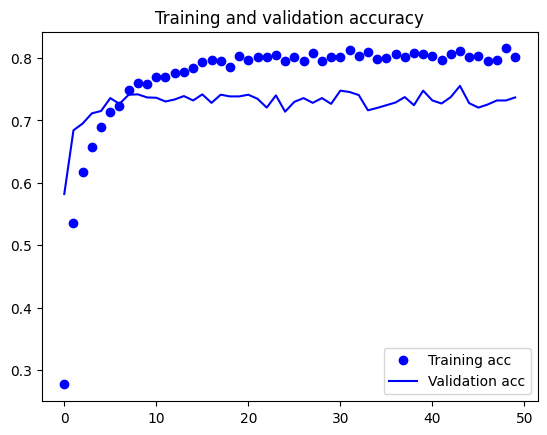

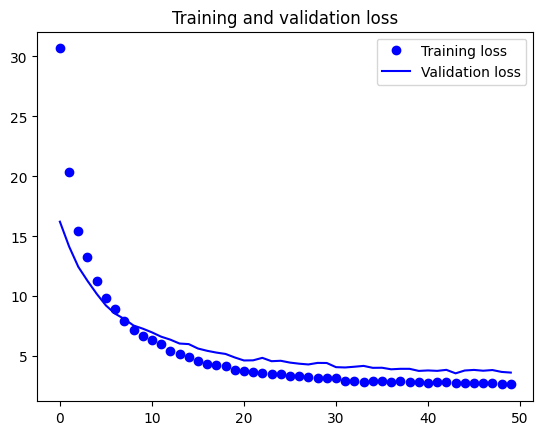

In [ ]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
vgg19_features_test = get_features(VGG19,
                                 vgg19_preprocessor,
                                  img_size, X_test)
Y_pred = model.predict(vgg19_features_test)
score = model.evaluate(vgg19_features_test, Y_test)
print('VGG19 Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 2s 45ms/step
Feature maps shape:  (1023, 512)
32/32 [==============================] - 0s 2ms/step - loss: 3.5222 - accuracy: 0.7410
VGG19 Test Set Accuracy: 
  74.1 %


In [12]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

288/288 [==============================] - 15s 20ms/step
Feature maps shape:  (9199, 2048)


In [ ]:
#Prepare Deep net
from keras.regularizers import l2
model = Sequential()
model.add(Dense(1028,input_shape=(inception_features.shape[1],)))
model.add(Dropout(0.7))
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(inception_features, Y,
            batch_size=batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
57/58 [============================>.] - ETA: 0s - loss: 6.1717 - accuracy: 0.0162

58/58 [==============================] - 1s 7ms/step - loss: 6.1644 - accuracy: 0.0160 - val_loss: 5.3049 - val_accuracy: 0.0109 - lr: 0.0010
Epoch 2/50
40/58 [===================>..........] - ETA: 0s - loss: 5.1114 - accuracy: 0.0158

58/58 [==============================] - 0s 4ms/step - loss: 5.0448 - accuracy: 0.0166 - val_loss: 4.8063 - val_accuracy: 0.0136 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 4.6548 - accuracy: 0.0323

58/58 [==============================] - 0s 4ms/step - loss: 4.6548 - accuracy: 0.0323 - val_loss: 4.4138 - val_accuracy: 0.0348 - lr: 0.0010
Epoch 4/50
40/58 [===================>..........] - ETA: 0s - loss: 4.3344 - accuracy: 0.0486

58/58 [==============================] - 0s 4ms/step - loss: 4.3232 - accuracy: 0.0477 - val_loss: 4.1265 - val_accuracy: 0.0783 - lr: 0.0010
Epoch 5/50
53/58 [==========================>...] - ETA: 0s - loss: 3.8817 - accuracy: 0.1086

58/58 [==============================] - 0s 4ms/step - loss: 3.8385 - accuracy: 0.1141 - val_loss: 3.0783 - val_accuracy: 0.2467 - lr: 0.0010
Epoch 6/50
40/58 [===================>..........] - ETA: 0s - loss: 2.4104 - accuracy: 0.4094

58/58 [==============================] - 0s 4ms/step - loss: 2.1788 - accuracy: 0.4855 - val_loss: 1.3568 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 7/50
39/58 [===================>..........] - ETA: 0s - loss: 1.4726 - accuracy: 0.7466

58/58 [==============================] - 0s 4ms/step - loss: 1.4368 - accuracy: 0.7572 - val_loss: 1.1863 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 8/50
41/58 [====================>.........] - ETA: 0s - loss: 1.1862 - accuracy: 0.8127

58/58 [==============================] - 0s 4ms/step - loss: 1.1535 - accuracy: 0.8171 - val_loss: 0.9909 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 9/50
58/58 [==============================] - ETA: 0s - loss: 0.9577 - accuracy: 0.8421

58/58 [==============================] - 0s 4ms/step - loss: 0.9577 - accuracy: 0.8421 - val_loss: 0.9054 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 10/50
56/58 [===========================>..] - ETA: 0s - loss: 0.8302 - accuracy: 0.8612

58/58 [==============================] - 0s 4ms/step - loss: 0.8261 - accuracy: 0.8623 - val_loss: 0.7978 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 11/50
40/58 [===================>..........] - ETA: 0s - loss: 0.7317 - accuracy: 0.8707

58/58 [==============================] - 0s 4ms/step - loss: 0.7296 - accuracy: 0.8695 - val_loss: 0.7448 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 12/50
58/58 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.8816

58/58 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.8816 - val_loss: 0.7014 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 13/50
57/58 [============================>.] - ETA: 0s - loss: 0.6043 - accuracy: 0.8941

58/58 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.8937 - val_loss: 0.6810 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 14/50
58/58 [==============================] - ETA: 0s - loss: 0.5763 - accuracy: 0.8951

58/58 [==============================] - 0s 4ms/step - loss: 0.5763 - accuracy: 0.8951 - val_loss: 0.6640 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 15/50
58/58 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.9052

58/58 [==============================] - 0s 4ms/step - loss: 0.5303 - accuracy: 0.9052 - val_loss: 0.6525 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 16/50
58/58 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.9076

58/58 [==============================] - 0s 4ms/step - loss: 0.5041 - accuracy: 0.9076 - val_loss: 0.6233 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 17/50
39/58 [===================>..........] - ETA: 0s - loss: 0.4845 - accuracy: 0.9083

58/58 [==============================] - 0s 4ms/step - loss: 0.4776 - accuracy: 0.9114 - val_loss: 0.5964 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 18/50
58/58 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.9205

58/58 [==============================] - 0s 4ms/step - loss: 0.4385 - accuracy: 0.9205 - val_loss: 0.5922 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 19/50
58/58 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.9181

58/58 [==============================] - 0s 4ms/step - loss: 0.4402 - accuracy: 0.9181 - val_loss: 0.5852 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 20/50
58/58 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.9216

58/58 [==============================] - 0s 4ms/step - loss: 0.4245 - accuracy: 0.9216 - val_loss: 0.5694 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 21/50
58/58 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.9265

58/58 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.9265 - val_loss: 0.5770 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 22/50
58/58 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.9311

58/58 [==============================] - 0s 4ms/step - loss: 0.3872 - accuracy: 0.9311 - val_loss: 0.5826 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 23/50
58/58 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.9281

58/58 [==============================] - 0s 4ms/step - loss: 0.3936 - accuracy: 0.9281 - val_loss: 0.6147 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 24/50
40/58 [===================>..........] - ETA: 0s - loss: 0.3772 - accuracy: 0.9307

58/58 [==============================] - 0s 4ms/step - loss: 0.3785 - accuracy: 0.9285 - val_loss: 0.5903 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 25/50
58/58 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.9307

58/58 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.9307 - val_loss: 0.5676 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 26/50
56/58 [===========================>..] - ETA: 0s - loss: 0.3680 - accuracy: 0.9330

58/58 [==============================] - 0s 4ms/step - loss: 0.3682 - accuracy: 0.9327 - val_loss: 0.5571 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 27/50
58/58 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.9372

58/58 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.9372 - val_loss: 0.5577 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 28/50
58/58 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.9357

58/58 [==============================] - 0s 4ms/step - loss: 0.3470 - accuracy: 0.9357 - val_loss: 0.5633 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 29/50
58/58 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.9390

58/58 [==============================] - 0s 4ms/step - loss: 0.3319 - accuracy: 0.9390 - val_loss: 0.5457 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 30/50
58/58 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.9416

58/58 [==============================] - 0s 4ms/step - loss: 0.3245 - accuracy: 0.9416 - val_loss: 0.5349 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 31/50
57/58 [============================>.] - ETA: 0s - loss: 0.3168 - accuracy: 0.9435

58/58 [==============================] - 0s 4ms/step - loss: 0.3172 - accuracy: 0.9433 - val_loss: 0.5584 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 32/50
58/58 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.9435

58/58 [==============================] - 0s 4ms/step - loss: 0.3168 - accuracy: 0.9435 - val_loss: 0.5554 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 33/50
39/58 [===================>..........] - ETA: 0s - loss: 0.3077 - accuracy: 0.9447

58/58 [==============================] - 0s 4ms/step - loss: 0.3164 - accuracy: 0.9405 - val_loss: 0.5665 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 34/50
58/58 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.9420

58/58 [==============================] - 0s 4ms/step - loss: 0.3137 - accuracy: 0.9420 - val_loss: 0.5537 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 35/50
40/58 [===================>..........] - ETA: 0s - loss: 0.3016 - accuracy: 0.9473

58/58 [==============================] - 0s 4ms/step - loss: 0.3017 - accuracy: 0.9480 - val_loss: 0.5406 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 36/50
58/58 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.9488

58/58 [==============================] - 0s 4ms/step - loss: 0.2943 - accuracy: 0.9488 - val_loss: 0.5542 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 37/50
57/58 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.9500

58/58 [==============================] - 0s 4ms/step - loss: 0.2894 - accuracy: 0.9501 - val_loss: 0.5475 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 38/50
58/58 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.9490

58/58 [==============================] - 0s 4ms/step - loss: 0.2895 - accuracy: 0.9490 - val_loss: 0.5523 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 39/50
58/58 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9485

58/58 [==============================] - 0s 4ms/step - loss: 0.2907 - accuracy: 0.9485 - val_loss: 0.5513 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 40/50
58/58 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9553

58/58 [==============================] - 0s 4ms/step - loss: 0.2725 - accuracy: 0.9553 - val_loss: 0.5413 - val_accuracy: 0.8946 - lr: 0.0010


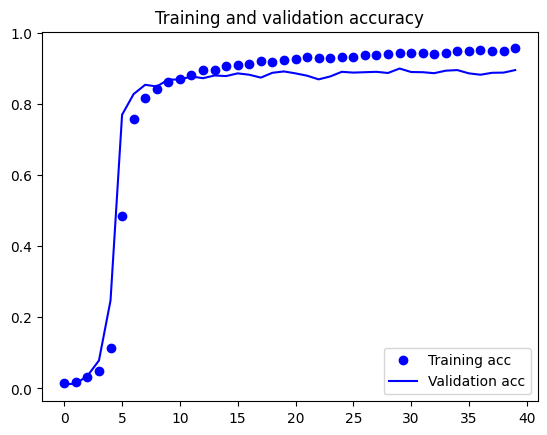

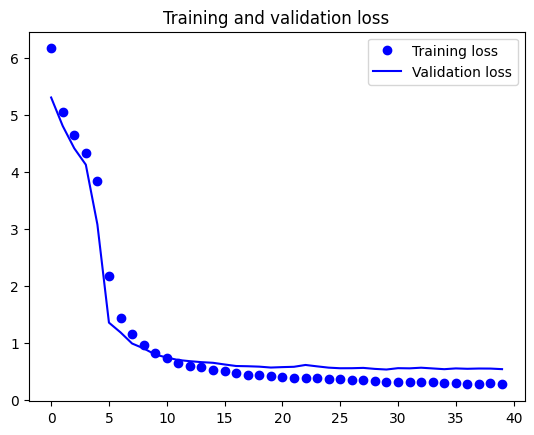

In [ ]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
#inception_features_test = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X_test)

32/32 [==============================] - 3s 55ms/step
Feature maps shape:  (1023, 2048)


In [ ]:
inception_features_test = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X_test)
Y_pred = model.predict(inception_features_test)
score = model.evaluate(inception_features_test, Y_test)
print('InceptionV3 Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 2s 19ms/step
Feature maps shape:  (1023, 2048)
32/32 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.8817
InceptionV3 Test Set Accuracy: 
  88.17 %


In [14]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

288/288 [==============================] - 9s 28ms/step
Feature maps shape:  (9199, 2048)


In [ ]:
#Prepare Deep net
model = Sequential()
model.add(Dense(1028,input_shape=(xception_features.shape[1],)))
model.add(Dropout(0.7))
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dropout(0.5))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#Training the model. 
history = model.fit(xception_features, Y,
            batch_size=batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
57/58 [============================>.] - ETA: 0s - loss: 4.6598 - accuracy: 0.2765

58/58 [==============================] - 1s 7ms/step - loss: 4.6481 - accuracy: 0.2782 - val_loss: 2.1501 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 2.7728 - accuracy: 0.6296

58/58 [==============================] - 0s 4ms/step - loss: 2.7728 - accuracy: 0.6296 - val_loss: 1.7297 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 2.1096 - accuracy: 0.7118

58/58 [==============================] - 0s 4ms/step - loss: 2.1096 - accuracy: 0.7118 - val_loss: 1.3982 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 4/50
55/58 [===========================>..] - ETA: 0s - loss: 1.7134 - accuracy: 0.7517

58/58 [==============================] - 0s 4ms/step - loss: 1.7080 - accuracy: 0.7535 - val_loss: 1.1918 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 5/50
55/58 [===========================>..] - ETA: 0s - loss: 1.4531 - accuracy: 0.7824

58/58 [==============================] - 0s 4ms/step - loss: 1.4483 - accuracy: 0.7837 - val_loss: 1.0479 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 6/50
56/58 [===========================>..] - ETA: 0s - loss: 1.2984 - accuracy: 0.8004

58/58 [==============================] - 0s 4ms/step - loss: 1.3005 - accuracy: 0.7994 - val_loss: 0.9568 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 7/50
57/58 [============================>.] - ETA: 0s - loss: 1.1677 - accuracy: 0.8146

58/58 [==============================] - 0s 4ms/step - loss: 1.1665 - accuracy: 0.8149 - val_loss: 0.8862 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 8/50
56/58 [===========================>..] - ETA: 0s - loss: 1.0685 - accuracy: 0.8291

58/58 [==============================] - 0s 4ms/step - loss: 1.0675 - accuracy: 0.8282 - val_loss: 0.8349 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 9/50
58/58 [==============================] - ETA: 0s - loss: 0.9794 - accuracy: 0.8375

58/58 [==============================] - 0s 4ms/step - loss: 0.9794 - accuracy: 0.8375 - val_loss: 0.7999 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 10/50
57/58 [============================>.] - ETA: 0s - loss: 0.9431 - accuracy: 0.8391

58/58 [==============================] - 0s 4ms/step - loss: 0.9441 - accuracy: 0.8392 - val_loss: 0.7714 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 11/50
58/58 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.8452

58/58 [==============================] - 0s 4ms/step - loss: 0.8878 - accuracy: 0.8452 - val_loss: 0.7442 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 12/50
58/58 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.8460

58/58 [==============================] - 0s 4ms/step - loss: 0.8608 - accuracy: 0.8460 - val_loss: 0.7183 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 13/50
58/58 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.8516

58/58 [==============================] - 0s 4ms/step - loss: 0.8358 - accuracy: 0.8516 - val_loss: 0.7084 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 14/50
58/58 [==============================] - ETA: 0s - loss: 0.8199 - accuracy: 0.8515

58/58 [==============================] - 0s 4ms/step - loss: 0.8199 - accuracy: 0.8515 - val_loss: 0.7137 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 15/50
58/58 [==============================] - ETA: 0s - loss: 0.7953 - accuracy: 0.8611

58/58 [==============================] - 0s 4ms/step - loss: 0.7953 - accuracy: 0.8611 - val_loss: 0.7039 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 16/50
58/58 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.8667

58/58 [==============================] - 0s 4ms/step - loss: 0.7701 - accuracy: 0.8667 - val_loss: 0.6893 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 17/50
57/58 [============================>.] - ETA: 0s - loss: 0.7442 - accuracy: 0.8668

58/58 [==============================] - 0s 4ms/step - loss: 0.7455 - accuracy: 0.8659 - val_loss: 0.6779 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 18/50
56/58 [===========================>..] - ETA: 0s - loss: 0.7344 - accuracy: 0.8644

58/58 [==============================] - 0s 4ms/step - loss: 0.7365 - accuracy: 0.8636 - val_loss: 0.6738 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 19/50
58/58 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.8729

58/58 [==============================] - 0s 4ms/step - loss: 0.7245 - accuracy: 0.8729 - val_loss: 0.6485 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 20/50
58/58 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.8743

58/58 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.8743 - val_loss: 0.6429 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 21/50
58/58 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.8762

58/58 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.8762 - val_loss: 0.6511 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 22/50
57/58 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.8831

58/58 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.8833 - val_loss: 0.6648 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 23/50
57/58 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.8813

58/58 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.8812 - val_loss: 0.6395 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 24/50
58/58 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.8846

58/58 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.8846 - val_loss: 0.6381 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 25/50
57/58 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.8806

58/58 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.8815 - val_loss: 0.6488 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 26/50
57/58 [============================>.] - ETA: 0s - loss: 0.6330 - accuracy: 0.8862

58/58 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.8854 - val_loss: 0.6225 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 27/50
58/58 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.8893

58/58 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.8893 - val_loss: 0.6421 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 28/50
57/58 [============================>.] - ETA: 0s - loss: 0.6341 - accuracy: 0.8869

58/58 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.8865 - val_loss: 0.6492 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 29/50
58/58 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.8891

58/58 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.8891 - val_loss: 0.6372 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 30/50
58/58 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.8883

58/58 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.8883 - val_loss: 0.6439 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 31/50
57/58 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.8951

58/58 [==============================] - 0s 4ms/step - loss: 0.5979 - accuracy: 0.8947 - val_loss: 0.6357 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 32/50
56/58 [===========================>..] - ETA: 0s - loss: 0.6053 - accuracy: 0.8902

58/58 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.8913 - val_loss: 0.6273 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 33/50
56/58 [===========================>..] - ETA: 0s - loss: 0.6176 - accuracy: 0.8880

58/58 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.8884 - val_loss: 0.6253 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 34/50
58/58 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.8901

58/58 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.8901 - val_loss: 0.6410 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 35/50
55/58 [===========================>..] - ETA: 0s - loss: 0.5978 - accuracy: 0.8964

58/58 [==============================] - 0s 4ms/step - loss: 0.5972 - accuracy: 0.8967 - val_loss: 0.6321 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 36/50
58/58 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.8952

58/58 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.8952 - val_loss: 0.6261 - val_accuracy: 0.9005 - lr: 0.0010


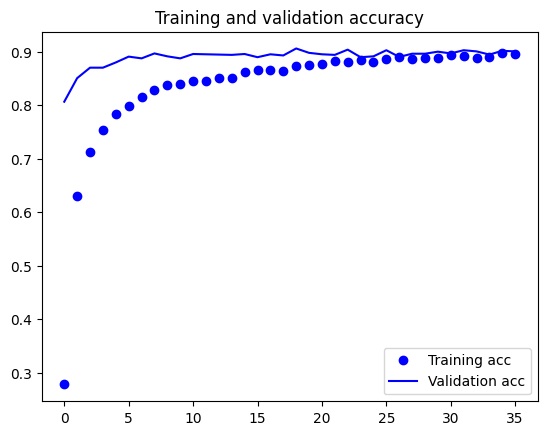

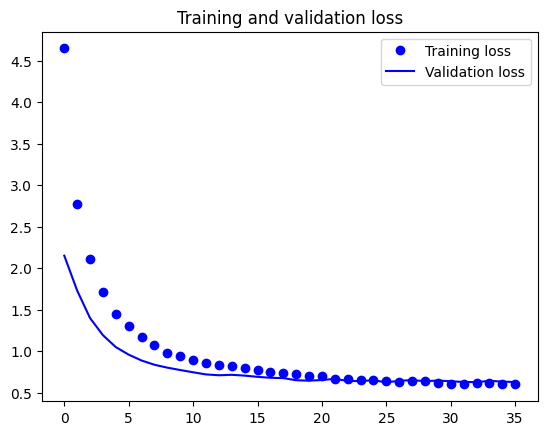

In [ ]:

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
#Xception_features_test = get_features(Xception,
                                  xception_preprocessor,
                                  img_size, X_test)

32/32 [==============================] - 2s 38ms/step
Feature maps shape:  (1023, 2048)


In [ ]:
#Predict using Xception
Xception_features_test = get_features(Xception,
                                  xception_preprocessor,
                                  img_size, X_test)
Y_pred = model.predict(Xception_features_test)
score = model.evaluate(Xception_features_test, Y_test)
print('Xception Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 2s 28ms/step
Feature maps shape:  (1023, 2048)
32/32 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.8935
Xception Test Set Accuracy: 
  89.35 %


In [16]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

288/288 [==============================] - 16s 43ms/step
Feature maps shape:  (9199, 1536)


In [ ]:
#Prepare Deep net
model = Sequential()
model.add(Dense(1028,input_shape=(inc_resnet_features.shape[1],)))
model.add(Dropout(0.7))
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dropout(0.5))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(inc_resnet_features, Y,
            batch_size=batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
39/58 [===================>..........] - ETA: 0s - loss: 6.1291 - accuracy: 0.0431

58/58 [==============================] - 1s 7ms/step - loss: 5.7784 - accuracy: 0.0523 - val_loss: 4.2262 - val_accuracy: 0.2201 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 3.8381 - accuracy: 0.2462

58/58 [==============================] - 0s 4ms/step - loss: 3.8381 - accuracy: 0.2462 - val_loss: 1.8550 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 2.5444 - accuracy: 0.6354

58/58 [==============================] - 0s 4ms/step - loss: 2.5444 - accuracy: 0.6354 - val_loss: 1.5660 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 2.0679 - accuracy: 0.7472

58/58 [==============================] - 0s 4ms/step - loss: 2.0679 - accuracy: 0.7472 - val_loss: 1.3688 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 5/50
40/58 [===================>..........] - ETA: 0s - loss: 1.7622 - accuracy: 0.7912

58/58 [==============================] - 0s 4ms/step - loss: 1.7284 - accuracy: 0.7933 - val_loss: 1.2303 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 6/50
39/58 [===================>..........] - ETA: 0s - loss: 1.5050 - accuracy: 0.8215

58/58 [==============================] - 0s 4ms/step - loss: 1.4843 - accuracy: 0.8201 - val_loss: 1.1002 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 7/50
58/58 [==============================] - ETA: 0s - loss: 1.3476 - accuracy: 0.8220

58/58 [==============================] - 0s 4ms/step - loss: 1.3476 - accuracy: 0.8220 - val_loss: 1.0133 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 8/50
58/58 [==============================] - ETA: 0s - loss: 1.1967 - accuracy: 0.8406

58/58 [==============================] - 0s 4ms/step - loss: 1.1967 - accuracy: 0.8406 - val_loss: 0.9270 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 9/50
58/58 [==============================] - ETA: 0s - loss: 1.1082 - accuracy: 0.8504

58/58 [==============================] - 0s 4ms/step - loss: 1.1082 - accuracy: 0.8504 - val_loss: 0.8679 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 10/50
58/58 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.8566

58/58 [==============================] - 0s 4ms/step - loss: 1.0130 - accuracy: 0.8566 - val_loss: 0.8235 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 11/50
58/58 [==============================] - ETA: 0s - loss: 0.9475 - accuracy: 0.8659

58/58 [==============================] - 0s 4ms/step - loss: 0.9475 - accuracy: 0.8659 - val_loss: 0.7931 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 12/50
58/58 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.8687

58/58 [==============================] - 0s 4ms/step - loss: 0.8910 - accuracy: 0.8687 - val_loss: 0.7598 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 13/50
54/58 [==========================>...] - ETA: 0s - loss: 0.8532 - accuracy: 0.8695

58/58 [==============================] - 0s 4ms/step - loss: 0.8540 - accuracy: 0.8704 - val_loss: 0.7416 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 14/50
58/58 [==============================] - ETA: 0s - loss: 0.8214 - accuracy: 0.8787

58/58 [==============================] - 0s 4ms/step - loss: 0.8214 - accuracy: 0.8787 - val_loss: 0.7431 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 15/50
58/58 [==============================] - ETA: 0s - loss: 0.8199 - accuracy: 0.8723

58/58 [==============================] - 0s 4ms/step - loss: 0.8199 - accuracy: 0.8723 - val_loss: 0.7217 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 16/50
39/58 [===================>..........] - ETA: 0s - loss: 0.7825 - accuracy: 0.8824

58/58 [==============================] - 0s 4ms/step - loss: 0.7850 - accuracy: 0.8827 - val_loss: 0.7112 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 17/50
57/58 [============================>.] - ETA: 0s - loss: 0.7586 - accuracy: 0.8847

58/58 [==============================] - 0s 4ms/step - loss: 0.7570 - accuracy: 0.8850 - val_loss: 0.6869 - val_accuracy: 0.9098 - lr: 0.0010
Epoch 18/50
58/58 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.8876

58/58 [==============================] - 0s 4ms/step - loss: 0.7498 - accuracy: 0.8876 - val_loss: 0.6928 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 19/50
58/58 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.8872

58/58 [==============================] - 0s 4ms/step - loss: 0.7313 - accuracy: 0.8872 - val_loss: 0.6787 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 20/50
40/58 [===================>..........] - ETA: 0s - loss: 0.7015 - accuracy: 0.8895

58/58 [==============================] - 0s 4ms/step - loss: 0.7048 - accuracy: 0.8888 - val_loss: 0.6522 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 21/50
40/58 [===================>..........] - ETA: 0s - loss: 0.6634 - accuracy: 0.8963

58/58 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.8951 - val_loss: 0.6657 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 22/50
39/58 [===================>..........] - ETA: 0s - loss: 0.6896 - accuracy: 0.8886

58/58 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.8886 - val_loss: 0.6642 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 23/50
39/58 [===================>..........] - ETA: 0s - loss: 0.6668 - accuracy: 0.8968

58/58 [==============================] - 0s 4ms/step - loss: 0.6686 - accuracy: 0.8954 - val_loss: 0.6390 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 24/50
40/58 [===================>..........] - ETA: 0s - loss: 0.6395 - accuracy: 0.9025

58/58 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.8974 - val_loss: 0.6377 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 25/50
58/58 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.8926

58/58 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.8926 - val_loss: 0.6516 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 26/50
39/58 [===================>..........] - ETA: 0s - loss: 0.6499 - accuracy: 0.9002

58/58 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.8985 - val_loss: 0.6408 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 27/50
58/58 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.8993

58/58 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.8993 - val_loss: 0.6331 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 28/50
40/58 [===================>..........] - ETA: 0s - loss: 0.6505 - accuracy: 0.8959

58/58 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.8962 - val_loss: 0.6352 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 29/50
39/58 [===================>..........] - ETA: 0s - loss: 0.6284 - accuracy: 0.8974

58/58 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.9003 - val_loss: 0.6238 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 30/50
40/58 [===================>..........] - ETA: 0s - loss: 0.6224 - accuracy: 0.8977

58/58 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.8955 - val_loss: 0.6541 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 31/50
58/58 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.9000

58/58 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.9000 - val_loss: 0.6214 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 32/50
39/58 [===================>..........] - ETA: 0s - loss: 0.6085 - accuracy: 0.8988

58/58 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.9003 - val_loss: 0.6384 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 33/50
40/58 [===================>..........] - ETA: 0s - loss: 0.6104 - accuracy: 0.8996

58/58 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.8969 - val_loss: 0.6138 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 34/50
41/58 [====================>.........] - ETA: 0s - loss: 0.6180 - accuracy: 0.9002

58/58 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.9039 - val_loss: 0.6238 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 35/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5880 - accuracy: 0.9102

58/58 [==============================] - 0s 4ms/step - loss: 0.5926 - accuracy: 0.9075 - val_loss: 0.6076 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 36/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5829 - accuracy: 0.9102

58/58 [==============================] - 0s 4ms/step - loss: 0.5883 - accuracy: 0.9073 - val_loss: 0.6153 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 37/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5965 - accuracy: 0.9066

58/58 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.9065 - val_loss: 0.6222 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 38/50
58/58 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.9028

58/58 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 0.9028 - val_loss: 0.6129 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 39/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5797 - accuracy: 0.9123

58/58 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.9096 - val_loss: 0.6233 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 40/50
39/58 [===================>..........] - ETA: 0s - loss: 0.5661 - accuracy: 0.9091

58/58 [==============================] - 0s 4ms/step - loss: 0.5712 - accuracy: 0.9079 - val_loss: 0.6249 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 41/50
58/58 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.9038

58/58 [==============================] - 0s 4ms/step - loss: 0.5968 - accuracy: 0.9038 - val_loss: 0.6249 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 42/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5643 - accuracy: 0.9086

58/58 [==============================] - 0s 4ms/step - loss: 0.5804 - accuracy: 0.9069 - val_loss: 0.6309 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 43/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5757 - accuracy: 0.9100

58/58 [==============================] - 0s 4ms/step - loss: 0.5793 - accuracy: 0.9075 - val_loss: 0.6305 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 44/50
58/58 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.9064

58/58 [==============================] - 0s 4ms/step - loss: 0.5799 - accuracy: 0.9064 - val_loss: 0.6331 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 45/50
40/58 [===================>..........] - ETA: 0s - loss: 0.5655 - accuracy: 0.9090

58/58 [==============================] - 0s 4ms/step - loss: 0.5733 - accuracy: 0.9080 - val_loss: 0.6236 - val_accuracy: 0.9163 - lr: 0.0010


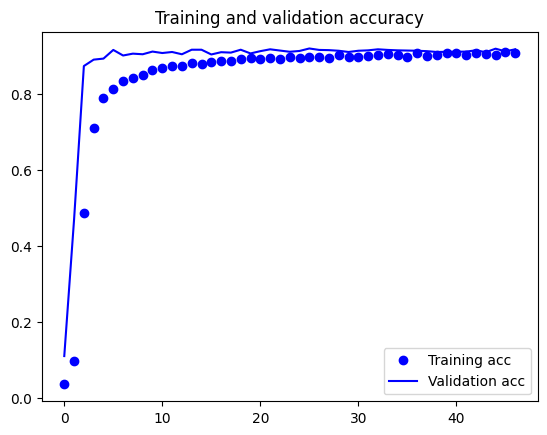

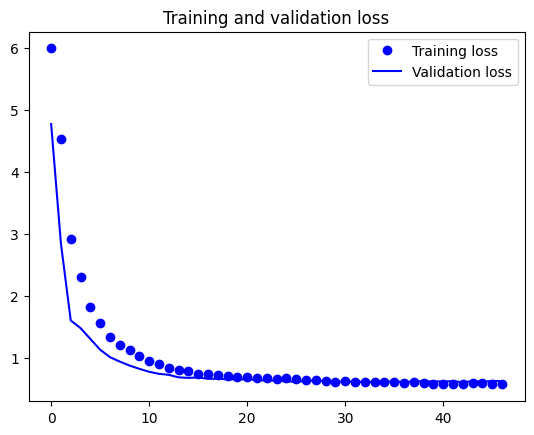

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
#inc_resnet_features_test = get_features(InceptionResNetV2,
 #                                 inc_resnet_preprocessor,
   #                               img_size, X_test)

32/32 [==============================] - 6s 66ms/step
Feature maps shape:  (1023, 1536)


In [ ]:
inc_resnet_features_test = get_features(InceptionResNetV2,
                                  inc_resnet_preprocessor,
                                  img_size, X_test)
Y_pred = model.predict(inc_resnet_features_test)
score = model.evaluate(inc_resnet_features_test, Y_test)
print('InceptionResNetV2 Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 4s 42ms/step
Feature maps shape:  (1023, 1536)
32/32 [==============================] - 0s 2ms/step - loss: 0.6182 - accuracy: 0.9150
InceptionResNetV2 Test Set Accuracy: 
  91.5 %


In [18]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

288/288 [==============================] - 36s 106ms/step
Feature maps shape:  (9199, 4032)


In [ ]:
#Prepare Deep net
model = Sequential()
model.add(Dense(1028,input_shape=(nasnet_features.shape[1],)))
model.add(Dropout(0.7))
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dropout(0.5))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(nasnet_features, Y,
            batch_size=batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
51/58 [=========================>....] - ETA: 0s - loss: 4.4136 - accuracy: 0.4926

58/58 [==============================] - 1s 8ms/step - loss: 4.2646 - accuracy: 0.5214 - val_loss: 2.4010 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 2/50
51/58 [=========================>....] - ETA: 0s - loss: 2.7602 - accuracy: 0.7756

58/58 [==============================] - 0s 4ms/step - loss: 2.7215 - accuracy: 0.7785 - val_loss: 1.9696 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 3/50
51/58 [=========================>....] - ETA: 0s - loss: 2.1349 - accuracy: 0.8249

58/58 [==============================] - 0s 4ms/step - loss: 2.1191 - accuracy: 0.8236 - val_loss: 1.5806 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 4/50
52/58 [=========================>....] - ETA: 0s - loss: 1.7149 - accuracy: 0.8468

58/58 [==============================] - 0s 4ms/step - loss: 1.7001 - accuracy: 0.8483 - val_loss: 1.3591 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 5/50
52/58 [=========================>....] - ETA: 0s - loss: 1.4264 - accuracy: 0.8700

58/58 [==============================] - 0s 4ms/step - loss: 1.4111 - accuracy: 0.8716 - val_loss: 1.1624 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 6/50
48/58 [=======================>......] - ETA: 0s - loss: 1.2237 - accuracy: 0.8771

58/58 [==============================] - 0s 4ms/step - loss: 1.2115 - accuracy: 0.8759 - val_loss: 1.0219 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 7/50
52/58 [=========================>....] - ETA: 0s - loss: 1.0558 - accuracy: 0.8872

58/58 [==============================] - 0s 4ms/step - loss: 1.0542 - accuracy: 0.8864 - val_loss: 0.9370 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 8/50
53/58 [==========================>...] - ETA: 0s - loss: 0.9803 - accuracy: 0.8878

58/58 [==============================] - 0s 4ms/step - loss: 0.9762 - accuracy: 0.8873 - val_loss: 0.8645 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 9/50
52/58 [=========================>....] - ETA: 0s - loss: 0.8841 - accuracy: 0.9008

58/58 [==============================] - 0s 4ms/step - loss: 0.8845 - accuracy: 0.9013 - val_loss: 0.8030 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 10/50
51/58 [=========================>....] - ETA: 0s - loss: 0.8461 - accuracy: 0.8986

58/58 [==============================] - 0s 4ms/step - loss: 0.8376 - accuracy: 0.8997 - val_loss: 0.7854 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 11/50
52/58 [=========================>....] - ETA: 0s - loss: 0.7761 - accuracy: 0.9032

58/58 [==============================] - 0s 4ms/step - loss: 0.7770 - accuracy: 0.9030 - val_loss: 0.7464 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 12/50
52/58 [=========================>....] - ETA: 0s - loss: 0.7391 - accuracy: 0.9059

58/58 [==============================] - 0s 4ms/step - loss: 0.7425 - accuracy: 0.9049 - val_loss: 0.7416 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 13/50
52/58 [=========================>....] - ETA: 0s - loss: 0.7290 - accuracy: 0.9097

58/58 [==============================] - 0s 4ms/step - loss: 0.7288 - accuracy: 0.9081 - val_loss: 0.7114 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 14/50
48/58 [=======================>......] - ETA: 0s - loss: 0.6755 - accuracy: 0.9123

58/58 [==============================] - 0s 5ms/step - loss: 0.6770 - accuracy: 0.9119 - val_loss: 0.6807 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 15/50
53/58 [==========================>...] - ETA: 0s - loss: 0.6491 - accuracy: 0.9136

58/58 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.9138 - val_loss: 0.6742 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 16/50
52/58 [=========================>....] - ETA: 0s - loss: 0.6270 - accuracy: 0.9139

58/58 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.9140 - val_loss: 0.6634 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 17/50
53/58 [==========================>...] - ETA: 0s - loss: 0.6117 - accuracy: 0.9175

58/58 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.9187 - val_loss: 0.6472 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 18/50
51/58 [=========================>....] - ETA: 0s - loss: 0.6001 - accuracy: 0.9187

58/58 [==============================] - 0s 4ms/step - loss: 0.5971 - accuracy: 0.9189 - val_loss: 0.6286 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 19/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5793 - accuracy: 0.9222

58/58 [==============================] - 0s 4ms/step - loss: 0.5828 - accuracy: 0.9208 - val_loss: 0.6342 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 20/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5711 - accuracy: 0.9226

58/58 [==============================] - 0s 4ms/step - loss: 0.5731 - accuracy: 0.9219 - val_loss: 0.6314 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 21/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5481 - accuracy: 0.9270

58/58 [==============================] - 0s 4ms/step - loss: 0.5507 - accuracy: 0.9262 - val_loss: 0.6197 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 22/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5593 - accuracy: 0.9247

58/58 [==============================] - 0s 4ms/step - loss: 0.5599 - accuracy: 0.9246 - val_loss: 0.6340 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 23/50
53/58 [==========================>...] - ETA: 0s - loss: 0.5337 - accuracy: 0.9307

58/58 [==============================] - 0s 4ms/step - loss: 0.5321 - accuracy: 0.9312 - val_loss: 0.6215 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 24/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5285 - accuracy: 0.9279

58/58 [==============================] - 0s 4ms/step - loss: 0.5288 - accuracy: 0.9276 - val_loss: 0.6111 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 25/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5235 - accuracy: 0.9318

58/58 [==============================] - 0s 4ms/step - loss: 0.5232 - accuracy: 0.9314 - val_loss: 0.6273 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 26/50
49/58 [========================>.....] - ETA: 0s - loss: 0.5212 - accuracy: 0.9298

58/58 [==============================] - 0s 4ms/step - loss: 0.5195 - accuracy: 0.9306 - val_loss: 0.6150 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 27/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4918 - accuracy: 0.9339

58/58 [==============================] - 0s 4ms/step - loss: 0.4999 - accuracy: 0.9329 - val_loss: 0.5932 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 28/50
51/58 [=========================>....] - ETA: 0s - loss: 0.5079 - accuracy: 0.9289

58/58 [==============================] - 0s 4ms/step - loss: 0.5059 - accuracy: 0.9300 - val_loss: 0.6083 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 29/50
52/58 [=========================>....] - ETA: 0s - loss: 0.5063 - accuracy: 0.9295

58/58 [==============================] - 0s 4ms/step - loss: 0.5059 - accuracy: 0.9288 - val_loss: 0.6029 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 30/50
51/58 [=========================>....] - ETA: 0s - loss: 0.4972 - accuracy: 0.9324

58/58 [==============================] - 0s 4ms/step - loss: 0.5007 - accuracy: 0.9314 - val_loss: 0.6051 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 31/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4888 - accuracy: 0.9363

58/58 [==============================] - 0s 4ms/step - loss: 0.4911 - accuracy: 0.9357 - val_loss: 0.5976 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 32/50
53/58 [==========================>...] - ETA: 0s - loss: 0.4822 - accuracy: 0.9316

58/58 [==============================] - 0s 4ms/step - loss: 0.4823 - accuracy: 0.9330 - val_loss: 0.6053 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 33/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4968 - accuracy: 0.9310

58/58 [==============================] - 0s 4ms/step - loss: 0.4979 - accuracy: 0.9311 - val_loss: 0.5996 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 34/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4744 - accuracy: 0.9369

58/58 [==============================] - 0s 4ms/step - loss: 0.4807 - accuracy: 0.9342 - val_loss: 0.6104 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 35/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4684 - accuracy: 0.9375

58/58 [==============================] - 0s 4ms/step - loss: 0.4695 - accuracy: 0.9369 - val_loss: 0.6031 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 36/50
53/58 [==========================>...] - ETA: 0s - loss: 0.4750 - accuracy: 0.9354

58/58 [==============================] - 0s 4ms/step - loss: 0.4748 - accuracy: 0.9359 - val_loss: 0.5942 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 37/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4709 - accuracy: 0.9381

58/58 [==============================] - 0s 4ms/step - loss: 0.4751 - accuracy: 0.9380 - val_loss: 0.5930 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 38/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4676 - accuracy: 0.9383

58/58 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.9369 - val_loss: 0.6043 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 39/50
50/58 [========================>.....] - ETA: 0s - loss: 0.4805 - accuracy: 0.9353

58/58 [==============================] - 0s 4ms/step - loss: 0.4764 - accuracy: 0.9359 - val_loss: 0.6104 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 40/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4588 - accuracy: 0.9426

58/58 [==============================] - 0s 4ms/step - loss: 0.4574 - accuracy: 0.9436 - val_loss: 0.6089 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 41/50
51/58 [=========================>....] - ETA: 0s - loss: 0.4486 - accuracy: 0.9407

58/58 [==============================] - 0s 4ms/step - loss: 0.4504 - accuracy: 0.9409 - val_loss: 0.6124 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 42/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4337 - accuracy: 0.9452

58/58 [==============================] - 0s 4ms/step - loss: 0.4358 - accuracy: 0.9443 - val_loss: 0.5950 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 43/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4301 - accuracy: 0.9447

58/58 [==============================] - 0s 4ms/step - loss: 0.4310 - accuracy: 0.9439 - val_loss: 0.5933 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 44/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4321 - accuracy: 0.9471

58/58 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.9480 - val_loss: 0.6133 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 45/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4320 - accuracy: 0.9419

58/58 [==============================] - 0s 4ms/step - loss: 0.4353 - accuracy: 0.9410 - val_loss: 0.5879 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 46/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4494 - accuracy: 0.9386

58/58 [==============================] - 0s 4ms/step - loss: 0.4473 - accuracy: 0.9390 - val_loss: 0.6077 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 47/50
53/58 [==========================>...] - ETA: 0s - loss: 0.4414 - accuracy: 0.9409

58/58 [==============================] - 0s 4ms/step - loss: 0.4458 - accuracy: 0.9401 - val_loss: 0.6057 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 48/50
53/58 [==========================>...] - ETA: 0s - loss: 0.4402 - accuracy: 0.9456

58/58 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.9459 - val_loss: 0.6358 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 49/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4286 - accuracy: 0.9443

58/58 [==============================] - 0s 4ms/step - loss: 0.4300 - accuracy: 0.9443 - val_loss: 0.6070 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 50/50
52/58 [=========================>....] - ETA: 0s - loss: 0.4454 - accuracy: 0.9422

58/58 [==============================] - 0s 4ms/step - loss: 0.4406 - accuracy: 0.9420 - val_loss: 0.6121 - val_accuracy: 0.9283 - lr: 0.0010


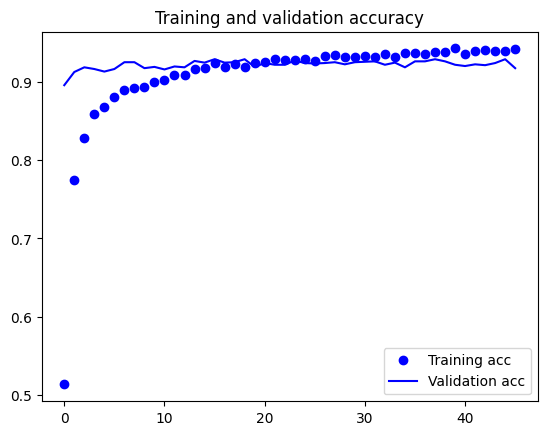

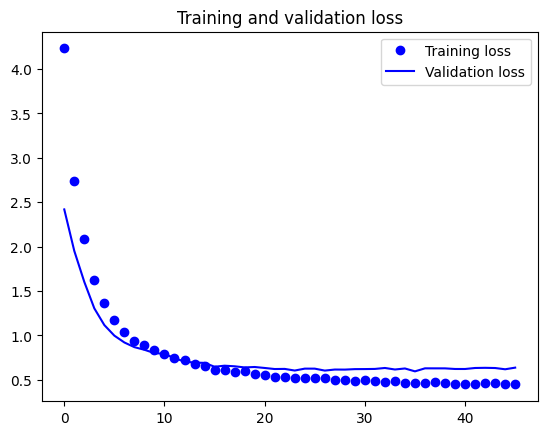

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
#nasnet_features_test = get_features(NASNetLarge,
      #                            nasnet_preprocessor,
        #                          img_size, X_test)

32/32 [==============================] - 9s 108ms/step
Feature maps shape:  (1023, 4032)


In [ ]:
#Predict using NASNetLarge
nasnet_features_test = get_features(NASNetLarge,
                                  nasnet_preprocessor,
                                  img_size, X_test)
Y_pred = model.predict(nasnet_features_test)
score = model.evaluate(nasnet_features_test, Y_test)
print('NASNetLarge Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 9s 107ms/step
Feature maps shape:  (1023, 4032)
32/32 [==============================] - 0s 2ms/step - loss: 0.5829 - accuracy: 0.9267
NASNetLarge Test Set Accuracy: 
  92.67 %


In [ ]:
del X #to free up some ram memory
gc.collect()

89768

In [20]:
#Creating final featuremap by combining all extracted features
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

Final feature maps shape (9199, 9664)


In [49]:
#Prepare Deep net
model = Sequential()
#model.add(Dense(1028, input_shape=(final_features.shape[1],), activation='relu', kernel_regularizer = 'l2'))
model.add(Dense(1028, input_shape=(final_features.shape[1],), activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))


model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, Y,
            batch_size=batch_size,
            epochs=100,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/100
54/58 [==========================>...] - ETA: 0s - loss: 2.8700 - accuracy: 0.4061

58/58 [==============================] - 1s 10ms/step - loss: 2.7723 - accuracy: 0.4227 - val_loss: 0.4235 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 2/100
55/58 [===========================>..] - ETA: 0s - loss: 0.9385 - accuracy: 0.7683

58/58 [==============================] - 0s 6ms/step - loss: 0.9363 - accuracy: 0.7698 - val_loss: 0.3383 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 3/100
54/58 [==========================>...] - ETA: 0s - loss: 0.6907 - accuracy: 0.8271

58/58 [==============================] - 0s 6ms/step - loss: 0.6869 - accuracy: 0.8280 - val_loss: 0.3111 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 4/100
55/58 [===========================>..] - ETA: 0s - loss: 0.5575 - accuracy: 0.8615

58/58 [==============================] - 0s 6ms/step - loss: 0.5526 - accuracy: 0.8618 - val_loss: 0.2994 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 5/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4960 - accuracy: 0.8710

58/58 [==============================] - 0s 6ms/step - loss: 0.4902 - accuracy: 0.8724 - val_loss: 0.2978 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 6/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4527 - accuracy: 0.8832

58/58 [==============================] - 0s 5ms/step - loss: 0.4483 - accuracy: 0.8845 - val_loss: 0.3221 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 7/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3581 - accuracy: 0.9012

58/58 [==============================] - 0s 5ms/step - loss: 0.3586 - accuracy: 0.9015 - val_loss: 0.3056 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 8/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3367 - accuracy: 0.9048

58/58 [==============================] - 0s 5ms/step - loss: 0.3389 - accuracy: 0.9043 - val_loss: 0.3104 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 9/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3168 - accuracy: 0.9127

58/58 [==============================] - 0s 5ms/step - loss: 0.3185 - accuracy: 0.9124 - val_loss: 0.3176 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 10/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3070 - accuracy: 0.9155

58/58 [==============================] - 0s 5ms/step - loss: 0.3036 - accuracy: 0.9163 - val_loss: 0.3278 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 11/100
52/58 [=========================>....] - ETA: 0s - loss: 0.2693 - accuracy: 0.9208

58/58 [==============================] - 0s 5ms/step - loss: 0.2745 - accuracy: 0.9209 - val_loss: 0.3272 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 12/100
53/58 [==========================>...] - ETA: 0s - loss: 0.2738 - accuracy: 0.9220

58/58 [==============================] - 0s 5ms/step - loss: 0.2725 - accuracy: 0.9217 - val_loss: 0.3252 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 13/100
55/58 [===========================>..] - ETA: 0s - loss: 0.2550 - accuracy: 0.9230

58/58 [==============================] - 0s 5ms/step - loss: 0.2563 - accuracy: 0.9231 - val_loss: 0.3327 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 14/100
54/58 [==========================>...] - ETA: 0s - loss: 0.2071 - accuracy: 0.9376

58/58 [==============================] - 0s 5ms/step - loss: 0.2119 - accuracy: 0.9367 - val_loss: 0.3450 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 15/100
53/58 [==========================>...] - ETA: 0s - loss: 0.2159 - accuracy: 0.9347

58/58 [==============================] - 0s 6ms/step - loss: 0.2213 - accuracy: 0.9349 - val_loss: 0.3434 - val_accuracy: 0.9402 - lr: 0.0010


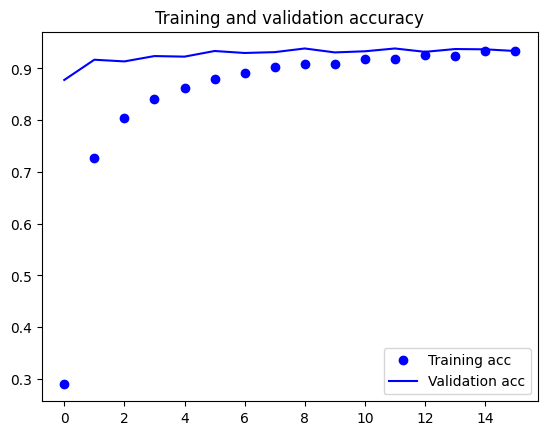

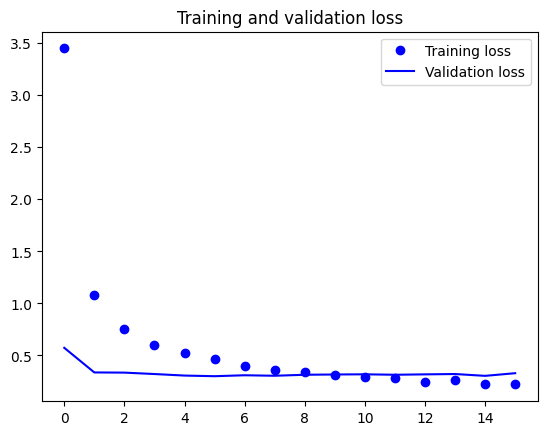

In [47]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

27335

In [50]:
#Predict using the Combination Model
final_features_test = np.concatenate([inception_features_test,
                                 Xception_features_test,
                                 nasnet_features_test,
                                 inc_resnet_features_test,], axis=-1)
Y_pred = model.predict(final_features_test)
score = model.evaluate(final_features_test, Y_test)
print('Final Model Test Set Accuracy: \n ', round((score[1]*100), 2), '%')

32/32 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.9326
Final Model Test Set Accuracy: 
  93.26 %
